## Andrej Karpathy: Zero-to-Hero

### [1. Micrograd](https://www.youtube.com/watch?v=VMj-3S1tku0&t=937s)
The spelled-out intro to neural networks and backpropagation: building micrograd, by Andrej Karpathy

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

%matplotlib inline

#### Part 1: Derivatives Review

$$f(x) = 3x^2 - 4x + 5$$

In [2]:
def f(x):
    return (3 * (x ** 2)) - (4 * x) + 5

In [3]:
f(3)

20

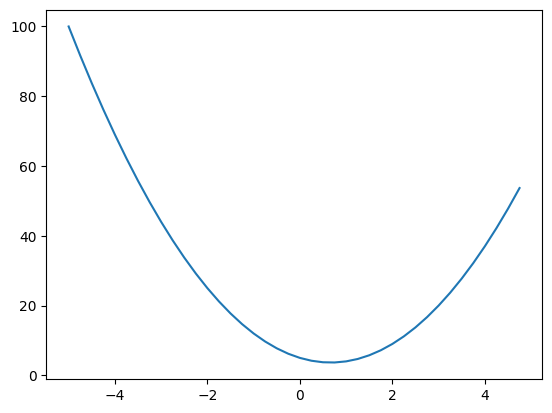

In [4]:
# Create an ndarray in the half-open interval 
# [-5, 5) with a step size of 0.25
xs = np.arange(-5, 5, 0.25)
ys = f(xs) # Can pass an array to this function
plt.plot(xs, ys)

Neural network expressions would be massive, and we won't take a symbolic approach to differentiating these large expressions. Instead, we will think about what a derivative is fundamentally.

From wikipedia, a function $f(x)$ is diffferentiable at $a$ if the limit $L$ exists

$$ L = \lim_{h \to 0}\frac{f(a + h) - f(a)}{h} $$

This is just the slope formula: $\frac{rise}{run}$. We increment the function at $a$ by an infinitesimally small amount $h$ and see how the function responds to find the slope at $a$. This is the derivative of the function as $a$, and represents the sensitivity of the function at that point, or how strongly it changes if we move a tiny amount along the $x$-axis. 



> Aside: There is no autocomplete for MathJax (latex math interpretor in VSCode markdown). A plugin for this would be very useful

In [5]:
def derivative(x, f=f, h=0.001):
    return (f(x + h) - f(x)) / h

def printValueAndDeriv(x):
    print("Value of function at %d:" % x, f(x))
    print("Sensitivity of function at %d:" % x, derivative(x))

In [6]:
# Some small value. The smaller it is, the more accurate the derivative
# (converges to the correct amount)
h = 0.001
x = 3.0

printValueAndDeriv(x)

Value of function at 3: 20.0
Sensitivity of function at 3: 14.00300000000243


$$f'(x) = 6x - 4$$
$$f'(3) = 14$$

Our approximation is close. The derivative at $x = -3$ should be negative, and larger in magnitude than 14.

The derivative should be about 0 around $x = 2/3$ (point where function does not respond, or where slope is 0).

In [7]:
printValueAndDeriv(-3)
print()
printValueAndDeriv(2/3)

Value of function at -3: 44
Sensitivity of function at -3: -21.996999999998934

Value of function at 0: 3.666666666666667
Sensitivity of function at 0: 0.0029999999995311555


#### Part 2: Multivaritate Equations

$$ d(a, b, c) = ab + c $$

> Aside: N-dimensional surfaces (N >= 3) can have infinite directional derivatives at some point A = [a1, a2, ...] (We can caluculate the slope of the surface if we much a small amount in any direction). The gradient is the largest directional directive of the function at A

In [8]:
def d(a, b, c):
    return a * b + c

# Returns the gradient of d at a, b, c
def dPrime(a, b, c, h=0.001):
    
    dellA = (d(a + h, b, c) - d(a, b, c)) / h
    dellB = (d(a, b + h, c) - d(a, b, c)) / h
    dellC = (d(a, b, c + h) - d(a, b, c)) / h

    return [dellA, dellB, dellC]

In [9]:
a = 2.0
b = -3.0
c = 10.0
d(a, b, c)

4.0

Let's move in the direction of $a$

$a$ becomes slighty larger, but since $b$ is negative, 
$a * b$ is smaller, and the functional value is smaller.
Thus, the slope in the $a$ direction at this point is negative.

In [10]:
# Let's move in the direction of a
d1 = d(a, b, c)
d2 = d(a + h, b, c)

print("d1", d1)
print("d2", d2)

print("slope", (d2 - d1) / h)

d1 4.0
d2 3.997
slope -3.0000000000001137


The partial derivative with respect to any of the independent variables is the sensitivity of the function with respect to that variable. It represents how sensitive the output is to a change in a particular variable. 

A partial derivative with a large magnitude implies that moving in the direction of that variable will result in a big change in the output of the function.

$$
\frac{\partial d}{\partial a} = b, 

\frac{\partial d}{\partial b} = a, 

\frac{\partial d}{\partial c} = 1
$$

In [11]:
print(dPrime(a, b, c))

# [partial a, partial b, partial c]
# The output matches the mathematical expressions above

[-3.0000000000001137, 1.9999999999997797, 0.9999999999994458]


The partial derivative of $c$ is independent of $a$ and $b$. If you add some amount to $c$, the function value increases by exactly that amount. So if $c$ is incremented by 5, then the function goes up by $5 * \frac{\partial d}{\partial c}$, or $5 * 1 = 5$. 

The reason I wrote out the partial derivative, is because I think this means d increases by 
1. the change in $a$ multiplied by its partial
2. the change in $b$ multiplied by its partial
3. and so on...

$$ d_{next} = d + \frac{\partial d}{\partial a} * \Delta a + \frac{\partial d}{\partial b} * \Delta b + \frac{\partial d}{\partial c} * \Delta c $$

In [12]:
# d1 is 4.0

# delta_b and delta_c are 0
# delta_a = h, and partial deriv. of d w.r.t. a = b

d_next = d1 + b * h

# Checks out.
print(d_next, d2)

3.997 3.997


#### Part 3: Value Object

Represents nodes in the computational graph. Children combine to produce a Value.

Note: This class was continually updated as I worked through the lecture. By the end, this class will contain the complete computational graph node implementation.

In [13]:
# Helper Methods

# These are copied from Part 6 below. You can find much better
# commented code there. This is here for a complete all-in-one
# implementation of autograd
def topologicalSort(root):

    topo = []
    visited = set()

    # recursive dfs
    def topoHelper(node, topo, visited):
        if node in visited:
            return 
        visited.add(node)

        for c in node._prev:
            topoHelper(c, topo, visited)
        topo.append(node)

    topoHelper(root, topo, visited)

    # returns nodes in reverse topologically sorted order
    return topo

# gradient descent
def gradientDescent(node, lr):
    
    # Not used in actual train function - this was my initial
    # solution to taking a gradient descent step before 
    # using the model.parameters() method based on the pytorch api

    # dfs
    visited = set()
    frontier = deque([node])
    while frontier:
        node = frontier.pop()
        if not node or node in visited:
            continue
        visited.add(node)

        # subtract to move in opposite direction of gradient.
        node.data -= lr * node.grad

        # This will change data values of all nodes, including
        # parent nodes. This is not a problem because those
        # parent.data members will be calculated from the children
        # in the forward pass.

        # zero-grad
        node.grad = 0

        for c in node._prev:
            frontier.append(c)


In [14]:
# Node in computational graph
# children combine to produce current Value
class Value:

    # input nodes have no children and no operator,
    # They are the 'leaves' of the computational graph
    
    # I believe we are using this "backwards" structure
    # where inputs are leaves and final outputs are roots
    # because we are preparing for backprop
    def __init__(self, data, _children=(), _op="", label=''):
        self.data = data
        self.grad = 0.0

        # default _backward function, ex. for a leaf, does nothing
        # We set the backward functions of parent nodes when creating them.
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op 
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    # Operators

    # Allow operating on constants (floats that are not wrapped in Value objects)
    # If val is not of type Value, assumes that it is a float
    def processOperand(self, val):
        return val if isinstance(val, Value) else Value(val)

    # a + b
    # left value will be self, right value will be other
    def __add__(self, val):
        val = self.processOperand(val)
        out = Value(self.data + val.data, (self, val), '+')

        # When parent calls _backward, its gradient is propagated
        # to us (its' children), and we update our gradients
        # using the chain rule. 
        def _backward():
            # local derivative * dFinal / dOut
            # Addition function: simply "route" parent gradient to me.
            # We do += because this node could be involved in other calculations
            # and thus could have multiple parents. The partial derivative in that case
            # is the sum of each dParent/dChild derivative. 
            self.grad += 1.0 * out.grad  
            val.grad += 1.0 * out.grad
        out._backward = _backward

        return out

    # right add to constant. Ex. 2 + a
    def __radd__(self, val):
        return self + val
        
    def __sub__(self, val):
        val = self.processOperand(val)
        out = Value(self.data - val.data, (self, val), '-')

        # Similar to __add__, but slight differences
        # next = self - val
        # deriv w.r.t val = -1
        # deriv w.r.t self = 1
        def _backward():
            self.grad += 1.0 * out.grad  
            val.grad += -1.0 * out.grad
        out._backward = _backward

        return out

    # right subtract from constant. Ex. 2 - a
    def __rsub__(self, val):
        return Value(val) - self

    def __mul__(self, val):
        val = self.processOperand(val)
        out = Value(self.data * val.data, (self, val), '*')

        def _backward():
            self.grad += val.data * out.grad
            val.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    # Ex. 2 * a
    def __rmul__(self, val):
        return self * val
    
    # Only supporting int/floats for val for now
    # TODO: Support Value objects
    def __pow__(self, val):
        assert(isinstance(val, (int, float)))

        out = Value(self.data ** val, (self,), f'**{val}')

        # power rule
        def _backward():
            self.grad += (val * (self.data ** (val - 1))) * out.grad
        out._backward =_backward
        
        return out

    # python3 uses __truediv__ for / 
    #          and __floordiv__ for //
    # Division implemented with __pow__ operator
    def __truediv__(self, val):
        out = self * (val ** -1.0)
        out._op = '/'
        return out

    # Originally implemented division operator.
    def atomic_div(self, val):
        val = self.processOperand(val)
        out = Value(self.data / val.data, (self, val), '/')

        # Similar to __mul__ but slight differences
        # next = self * (val)^-1
        # dNext/dVal = -1 * self * (val)^-2
        # dNext/dSelf = 1 / val
        def _backward():
            self.grad += (1.0 / val.data) * out.grad
            val.grad += (-1.0 * self.data * (val.data ** -2.0)) * out.grad
        out._backward = _backward
        return out

    def exp(self):
        val = math.exp(self.data)
        out = Value(val, (self,), 'exp')
        
        # derivative of e^x = e^x
        # next = exp(self)
        # dNext/dSelf = exp(self)
        def _backward():
            self.grad += val * out.grad
        out._backward = _backward

        return out

    def tanh(self):
        expVal = (self * 2.0).exp()
        val = (expVal - 1.0) / (expVal + 1.0)

        # Each atomic function used in the expression above will 
        # provided its own _backward function, with division 
        # being the first function differntiated during backprop
        return val  

    # We can write out the tanh function explicitly by implementing
    # __sub__, __div__, and exp. But it's not necessary to have 
    # these atomic computational pieces. You can have something as 
    # simple as an addition operator or something arbitrarily complex, 
    # but the most important thing is that you know how to differentiate
    # the function you implement so you compute the "local" partial derivative.
    def atomic_tanh(self):
        x = self.data
        val = (math.exp(2.0 * x) - 1.0) / (math.exp(2.0 * x) + 1.0)
        out = Value(val, (self,), 'tanh')
        
        def _backward():
            self.grad += (1.0 - val ** 2.0) * out.grad
        out._backward = _backward
        return out
    
    # I can implement this with atomic operations I've already written
    def mse(self, val):
        val = self.processOperand(val)
        out = (val - self) ** 2
        return out
    
    # --- AUTOGRAD ---
    
    def backward(self):
        # can run autograd with any node being the "global" function
        # against which each variable is differentiated. Just need to 
        # set my grad to 1 (base case) before running backward
        
        self.grad = 1 # base case
        rev = topologicalSort(self)
        for i in range(len(rev) - 1, -1, -1):
            rev[i]._backward()

    # --- deprecated --- 
    def optimize(self, lr=0.001):
        gradientDescent(self, lr)

# TODO:
# Would be very cool to implement more operators, such as log, sigmoid,
# ReLU, etc. and other non-linearities, along with things like self-attention

In [15]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
a + b # same as a.__add__(b)

Value(data=-1.0)

In [16]:
e = a * b; e.label = "e"
d = e + c; d.label = "d"
f = Value(-2.0, label="f")

L = d * f; L.label = "L"
print(L)
print(L._prev)
print(L._op)

Value(data=-8.0)
{Value(data=-2.0), Value(data=4.0)}
*


##### Graph Visualization using graphviz
Graphviz is an open source graph visualization library. Used the very basics to visualize the graph, but the library is very powerful and has many configurable options, and can be used to save graphs locally as well.

In [17]:
from graphviz import Digraph

In [18]:
def getGraph(root):

    adjList = {}

    frontier = deque([root])
    while frontier:
        node = frontier.pop()
        if not node:
            continue
        adjList[node] = set()

        for c in node._prev:
            adjList[node].add(c)
            frontier.append(c)
    
    return adjList

def graphVisualizer(root):

    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) 
    # LR: left-to-right (default is vertical)
    
    adjList = getGraph(root)
    for node in adjList:
        # shape: record - uses rectangle for data. Without specifiying, defaults to ovals for operators
        # { %s | ... } I think this is special syntax for graphviz to obtain the bar separator 
        dot.node(str(id(node)), 
                "{ %s | data: %.4f | grad: %.4f  }" % (node.label, node.data, node.grad), 
                shape="record")

    # The actual adjList is "backwards": the final output is the parent.
    # We want to display the forward pass, so we will flip the edges
    for node, children in adjList.items():
        # id(obj) returns unique integer identifier for obj
        uid = str(id(node))
        if node._op:
            opNodeId = uid + node._op
            dot.node(opNodeId, node._op)
            dot.edge(opNodeId, uid)
            for c in children:
                dot.edge(str(id(c)), opNodeId)

    return dot

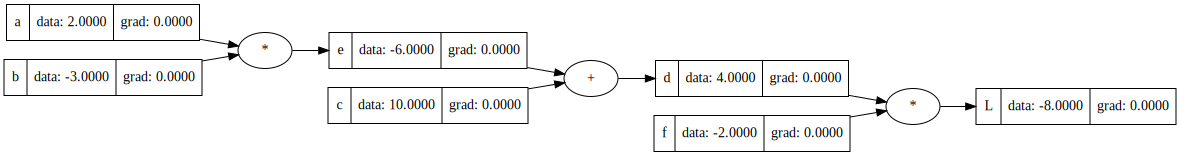

In [19]:
graphVisualizer(L)

#### Part 4: Backpropogation!
So far, we've completed the forward pass. Now it's time for backprop. To do this, we will compute the derivative of L (loosely representing a loss function) with respect to each parameter in the network. Currently, we only have inputs and intermediate values. But with an actual neural net, we'll have weights, and the goal will be to find the gradient of the loss with respect to those weights. 

First, we will update the Value object to keep track of the current gradient value. 

Let's do manual backprop. Full equation: 

$ L(a, b, c, f) = (a * b + c) * f $

Current values:
- $a: 2$
- $b: -3$
- $e: a * b = -6$
- $c: 10$
- $d: c + e = 4$
- $f: -2$
- $L: f * d = 8$

Partial Derivatives;
- $\frac{\partial L}{\partial L}$ = 1

- $\frac{\partial L}{\partial a} = \frac{\partial e}{\partial a} * \frac{\partial d}{\partial e} * \frac{\partial L}{\partial d} =  f * b = -2 * -3 = 6$

- $\frac{\partial L}{\partial b} = \frac{\partial e}{\partial b} * \frac{\partial d}{\partial e} * \frac{\partial L}{\partial d} = f * a = -2 * 2 = -4$

- $\frac{\partial L}{\partial c} = \frac{\partial d}{\partial c} * \frac{\partial L}{\partial d} = f * a = -2 * 2 = -4 = -2$

- $\frac{\partial L}{\partial f} = (a * b) + c = 4$

Chain Rule:
Product of rates of change


- $\frac{\partial L}{\partial e} = \frac{\partial d}{\partial e} * \frac{\partial L}{\partial d} $
    
    - $\frac{\partial L}{\partial e} = 1 * f = -2$

- $\frac{\partial L}{\partial d} = f = -2$

- $\frac{\partial L}{\partial f} = d = -4$

In [20]:
# Let's take a manual partial derivative with h = 0.001

def funcE(a, b):
    return a * b

def funcD(c, e):
    return c + e

def funcL(f, d):
    return f * d 

def derivL(a, b, c, f, h=0.001):
    e = funcE(a, b)
    d = funcD(c, e)
    L = funcL(f, d)

    dellD_E = (funcD(c, e + h) - d) / h
    dellD_C = (funcD(c + h, e) - d) / h
    dellE_A = (funcE(a + h, b) - e) / h
    dellE_B = (funcE(a, b + h) - e) / h

    dellL_F = (funcL(f + h, d) - L) / h
    dellL_D = (funcL(f, d + h) - L) / h
    dellL_E = dellD_E * dellL_D
    dellL_C = dellD_C * dellL_D
    dellL_B = dellE_B * (dellD_E * dellL_D) # The value in the parens is equal to dellL_E 
    dellL_A = dellE_A * (dellD_E * dellL_D) # The value in the parens i equal to dellL_D

    # There's a clear pattern!! And it's quite literally backprop with the chain rule
    # Each gradient in layer L - 1 is caluclated with the gradients already calculated in 
    # layer L.

    return {
        "A": dellL_A,
        "B": dellL_B,
        "C": dellL_C,
        "E": dellL_E,
        "D": dellL_D,
        "F": dellL_F
    }

derivL(2, -3, 10, -2)

# Looks right.

{'A': 6.000000000004235,
 'B': -4.000000000002231,
 'C': -1.9999999999995595,
 'E': -2.000000000001336,
 'D': -2.000000000000668,
 'F': 3.9999999999995595}

The base case is the partial derivative of $L$ w.r.t. $L$ which is just 1. So we can start here.

My thoughts: At each node $x^{(L-1)}_k$, calculate $\frac{dx^{(L)}_j}{dx^{(L-1)}_k}$ for a node $x^{(L)}_j$ it's connected to using the derivative limit formula. The value of the gradient in $x^{(L)}_j$ will be $\frac{dL}{dx^{(L)}_j}$. So to get $\frac{dL}{dx^{(L-1)}_k}$, we simply need to multiply.
$$
\frac{dL}{dx^{(L-1)}_k} = \frac{dx^{(L)}_j}{dx^{(L-1)}_k} * \frac{dL}{dx^{(L)}_j}
$$

In our graph structure, the parent nodes are $x^{(L)}_j$ and the children nodes are $x^{(L-1)}_k$, and the parents send their $\frac{dL}{dx^{(L)}_j}$ to their children.

Note from Andrej
- A plus node "routes" the derivative after it to the nodes before. It will "distribute" the derivative to all the children involved in the sum. This is because the derivative of a sum of two variables is simply 1 (regardless of which variable with respect to which you're deriving). 
- This is one of the same equations from above, but it helps illustrate this point. $e$ is part of a sum with $c$, and $\frac{\partial L}{\partial e}$ is simply equal to $\frac{\partial L}{\partial d}$ since the derivative of a sum is simply 1. 

- $\frac{\partial L}{\partial e} = \frac{\partial d}{\partial e} * \frac{\partial L}{\partial d} $
    
    - $\frac{\partial d}{\partial e} = 1$

In [21]:
L.grad = 1
f.grad = d.data
d.grad = f.data
e.grad = 1 * d.grad
c.grad = 1 * d.grad
b.grad = a.data * e.grad
a.grad = b.data * e.grad

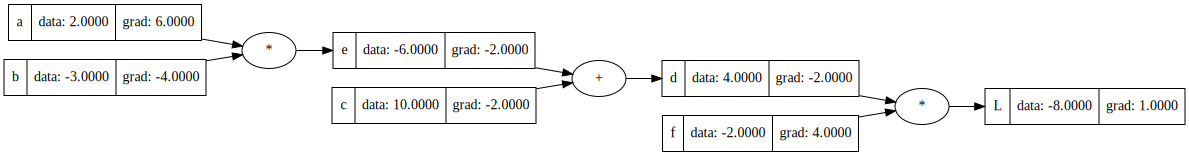

In [22]:
# Let's redraw the graph
graphVisualizer(L)

Summary of Backpropogation: Recursive application of the chain rule. 

##### 4.1 Sneak peek at optimization
Let's say we want to change `a.data` to make `L` go up. So we simply want to move in the direction of the gradient. 
Currently, `L.data = -8`

We can add the partial derivatives of each variable to the variable itself. We only do it to the leaf nodes, which are the nodes we have control over (e and d are intermediate nodes)

- I initially used a step size of 1, and it lowered the value of L drastically. Why is this? 
    - I think it's because the gradient simply gives us the direction to move in. It is very possible that if we take a large step in the gradient direction, we "jump over" the local maximum that we thought we were heading towards, and end up worse than before.

In [23]:
step = 0.01

a.data += step * a.grad
b.data += step * b.grad
c.data += step * c.grad
f.data += step * f.grad

# Re-run the forward pass
e = a * b
d = c + e
L = f * d

L

Value(data=-7.286496)

> Random thought: The ReLU non-linearity is almost a linear function. So the output of an MLP using ReLUs is a piecewise function with bits and pieces of the ReLU covering a small part of the domain of the input. Why do we need a ReLU then? Can't this similar piecewise logic also work with the identity function? How does the "activation" (max(0, x)) component of a ReLU make it useful?
- [Stack overflow answer](https://ai.stackexchange.com/questions/36272/why-cannot-linear-activation-functions-be-used-to-approximate-any-function)

#### Part 5: Backprop with Neurons

We'll use $\tanh$ as our non-linearity. $\sigma(x)$ is the sigmoid function, and I include it here to show the relationship between the two. 

$$\sigma(x) = \frac{e^x}{1 + e^x} $$

$$\tanh{z} = 2 * \sigma(2x) - 1$$

$$\tanh{z} = \frac{e^z - e^{-z}}{e^z + e^{-z}}$$

**Sigmoid vs. tanh**

- Range of $\tanh$ is [-1, 1], whereas sigmoid is [0, 1]. Thich helps avoid bias in gradients (I don't know what this means, and it's explained in the paper by [LeCun et al.](http://yann.lecun.com/exdb/publis/pdf/lecun-98b.pdf))
- Moreover, "sigmoid has a slower rate of change than $\tanh$, which means that the derivative of the sigmoid function will be smaller than the derivative of the $\tanh$ function for a given input." So $\tanh$ has stronger gradients. 
- "...sigmoid is often used in the output layer of a binary classification network (to assign probabilities) while the $\tanh$ is often used in hidden layers" (Anish)

References
- [Anish Shreshta Medium Article](https://anyesh.medium.com/relationship-between-sigmoid-and-tanh-activation-function-53d289889d9a)
- Stack overflow answers, graphically shows the difference in derivative size: [link](https://stats.stackexchange.com/questions/101560/tanh-activation-function-vs-sigmoid-activation-function)
    - One of the answers elaborates on the bias problem

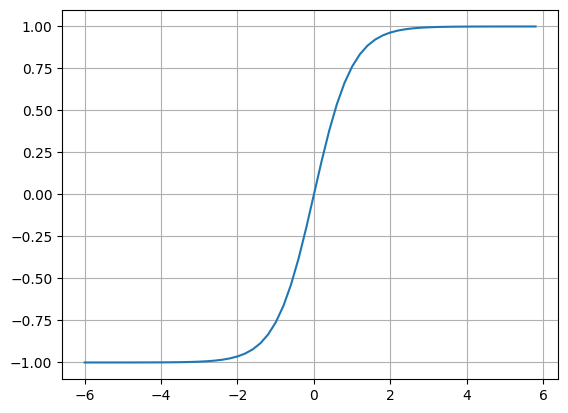

In [24]:
xs = np.arange(-6, 6, 0.2)
ys = np.tanh(xs)
plt.plot(xs, ys)
plt.grid()

**Simple MLP**

**cs231n Neuron**


![**cs231n Neuron**](./img/neuron_model.jpeg)

See my 3b1b neural network notes for an in-depth discussion of MLPs.

In [25]:
# Globals aren't the cleanest solution, and using a class would be better
# But this is the most convenient

x1 = x2 = w1 = w2 = b = x1w1 = x2w2 = wSum = n = o = None
def resetTestNeuron(atomic_tanh=True):

    global x1; global x2; global w1; global w2; global b
    global x1w1; global x2w2; global wSum; global n; global o

    x1 = Value(2.0, label='x1')
    x2 = Value(0.0, label='x2')

    # weights w1,w2
    w1 = Value(-3.0, label='w1')
    w2 = Value(1.0, label='w2')

    # bias of the neuron
    # set by Andrej to ensure that backprop weights are simple
    b = Value(6.8813735870195432, label='b')

    # x1 * w1 + x2 * w2 + b
    x1w1 = x1*w1; x1w1.label = 'x1*w1'
    x2w2 = x2*w2; x2w2.label = 'x2*w2'

    # sum of weighted inputs
    wSum = x1w1 + x2w2; wSum.label = 'x1*w1 + x2*w2'

    # add bias
    n = wSum + b; n.label = 'n'

    # Activation
    o = n.atomic_tanh() if atomic_tanh else n.tanh(); o.label = 'o'
resetTestNeuron()

The code above is almost identical to the neuron described
by the image. The only difference is that there are only
two inputs instead of 3.

With `b=6.7`, `n=0.7` and thus the activation doesn't squash it much. If we set `b=8.0,` then `n=2.0` and the activation squashes the value down to `0.9640`

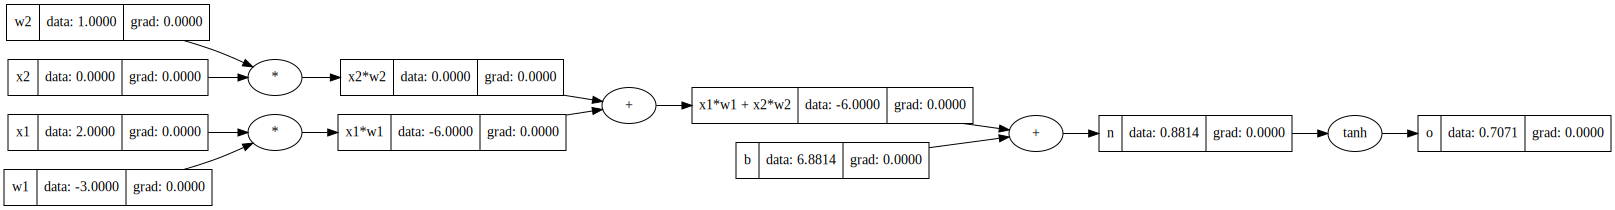

In [26]:
# Refresh this anytime we make changes to any of the parameters
graphVisualizer(o)

**Backprop time!**

Our goal is optimize `w1` and `w2` since those are the only parameters we can tweak.

Note that this is simply 1 neuron for sake of learning, and actual MLPs contain wayyy more neurons. And ultimately there is some loss function and we differentiate with respect to the loss. 

In [27]:
o.grad = 1 # base case

We need to find the local derivative $\frac{do}{dn}$. The derivative of $\tanh$ according to wikipedia is: 

$$
\frac{do}{dn} = 1 - \tanh^2{n}
$$

and we have $\tanh(n)$, it's simply $o$.

In [28]:
n.grad = 1 - o.data ** 2 # 0.5

Now we need $\frac{do}{dwSum}$ which equals
$$
\frac{dn}{dwSum} * \frac{do}{dn} = 1 * n.grad
$$

As we mentioned before, the plus operator "routes" the derivative in the next node to the previous node since the derivative of the plus function is simply 1. Same logic applies for deriving with respect to the bias.

$$
\frac{do}{db} = \frac{dn}{db} * \frac{do}{dn} = 1 * n.grad
$$

In [29]:
wSum.grad = n.grad
b.grad = n.grad

$$
\frac{do}{dx1w1} = \frac{dwSum}{dx1w1} * \frac{do}{dwSum} = \frac{do}{dwSum}
$$

$\frac{dwSum}{dx1w1}$ is the derivative of yet another sum. We simply propogate $\frac{do}{dwSum}$ backwards. Same logic applies for deriving with respect to $x2w2$

In [30]:
x1w1.grad = wSum.grad
x2w2.grad = wSum.grad

$$
\frac{do}{dw1} = \frac{dx1w1}{dw1} * \frac{do}{dx1w1} = x1 * \frac{do}{dx1w1}
$$

Here we have a multiplication operator. When we differentiate with respect to $w1$, we are left with $x1$. In this case, we don't need to calculate the gradient for $x1$ since it is not a parameter we can control.

We do the same with $w2$

$$
\frac{do}{dw2} = \frac{dx2w2}{dw2} * \frac{do}{dx2w2} = x2 * \frac{do}{dx2w2}
$$

In [31]:
w1.grad = x1.data * x1w1.grad
w2.grad = x2.data * x2w2.grad

# For sake of completion
x1.grad = w1.data * x1w1.grad
x2.grad = w2.data * x2w2.grad

The actual value of w2.grad is 0. If you look at the computation graph, this makes sense. The derivative tells you how much changing a variable will affect the output. x2 and w2 are combined by a multiplication operator, and x2 is 0. 

Which means that regardless of the value of w2, $x2 * w2$ will always equal 0. So changing w2 doesn't affect the output, and thus the gradient is 0.

--

That's the entire backward pass through this single neuron. We can see that to make $o$ increase, we need to increase $w1$ and $b$ by some small amount, and changing $w2$ currently does not affect the final output.

Manual backprop ise excruciating. It's time for...

#### Part 6: AUTOGRAD!

I add a `_backward` function to the Value object. Each operator implemented in the `Value` class must set its newly created parent's `_backward` function. Whenever the parent calls this function, the children's gradient value is updated using the chain rule by multiplying the "local derivative" by the parent's gradient.

In [32]:
# Reset MLP Neuron
resetTestNeuron(True)

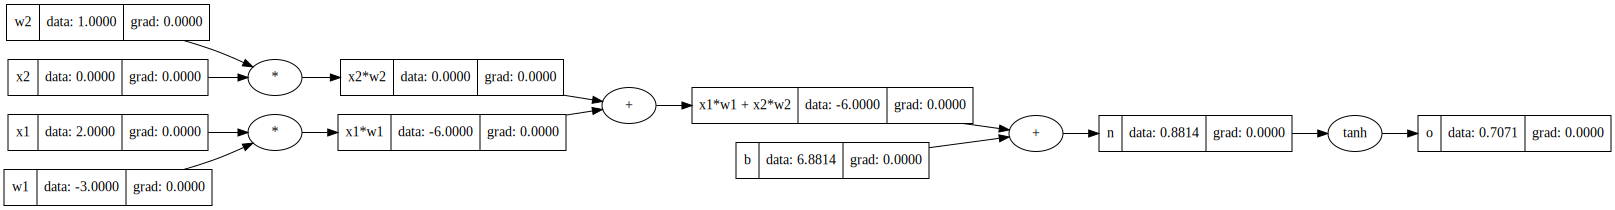

In [33]:
graphVisualizer(o)

This next approach was my first attempt, and it's actually wrong, even though it obtains the right results in this particular case.

In [34]:
def bfsBackward(root):
    # Need to do bfs traversal
    # (Do we *need* bfs? I think dfs might work too...)

    # need to set base case
    root.grad = 1
    frontier = deque([root])
    while frontier:
        node = frontier.popleft()
        if not node:
            continue
        node._backward()
        for c in node._prev:
            frontier.append(c)

In [35]:
# bfsBackward(o)
# graphVisualizer(o)

# Observation: if a node is used as the input for only one 
# other activation in a subsequent layer, this works. However,
# take an example where there is no w2, and w1 below is multiplied
# to both x1 and x2. In this case, w1's partial derivative is 
# dependent on both x1w1 and x2w1. Particularly, it's the sum
# dx1w1/dw1 + dx2w1/dw1. 

**What's the problem?** 

We *need* to make sure that we don't try to compute gradients of children nodes until the gradients of all of its parents are computed. We haven't created an examples in which one weight is a part of operations with multiple other nodes. In fact, everything we've seen so far has been a tree. Consider this:

in the graph above, let w3 be a weight connected to both x1 and n. When we call `_backward` on `n`, `bfs` will add w3 to the frontier and operate on it before the gradient for x1 is ever calculated. This will result in an incorrect gradient calculation for w3.

What we need is to make sure that the nodes are considered in an ordered manner, where the prerequisites of a node are all completed before the node itself... we need TOPOLOGICAL SORTING!

--- 
**Multiple incoming edges problem:** 

The way to solve the problem mentioned in the python comment above about one node with 2 parents: 
- simply ADD to (accumulate) the children's grad values in the backward function instead of simply setting them equal to the current calculation of local derivative * global derivative.
- I am saying 2 parents, but what I mean is we need to account for each incoming edge into the node. I make this distinction because you can have a case like `b = a + a + a`. It's just 1 parent node, but with 3 edges from `b` to `a`.

Update: Andrej confirmed this edge case and solution in the "fixing a backprog bug" section of the lecture.

In [36]:
# Unlike an arbitrary graph, if you start at the root of a computational
# graph, you will reach every node in the graph. Every node must somehow lie
# along the path from root to leaves (inputs). There also won't be
# any cycles in a valid equation which doesn't have circular dependencies.

def topologicalSort(root):

    # Idea: dfs until you hit a node with no children.
    # Add that node to the list. As you back track, add nodes to list.
    # don't expand nodes you've already seen

    topo = []
    visited = set()
    topoHelper(root, topo, visited)

    # returns nodes in reverse topologically sorted order
    return topo

# recursive dfs
def topoHelper(node, topo, visited):
    if node in visited:
        return 
    visited.add(node)

    # If I have children, search them first
    # before adding myself. Nodes with no children
    # get added to topo immediately.
    for c in node._prev:
        topoHelper(c, topo, visited)
    topo.append(node)


In [37]:
topologicalSort(o)

# Doesn't have to, but matches exactly with Andrej's sort
# (topological sorts are not unique)

[Value(data=6.881373587019543),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [38]:
def backward(root):
    root.grad = 1 # base case
    rev = topologicalSort(root)
    for i in range(len(rev) - 1, -1, -1):
        rev[i]._backward()

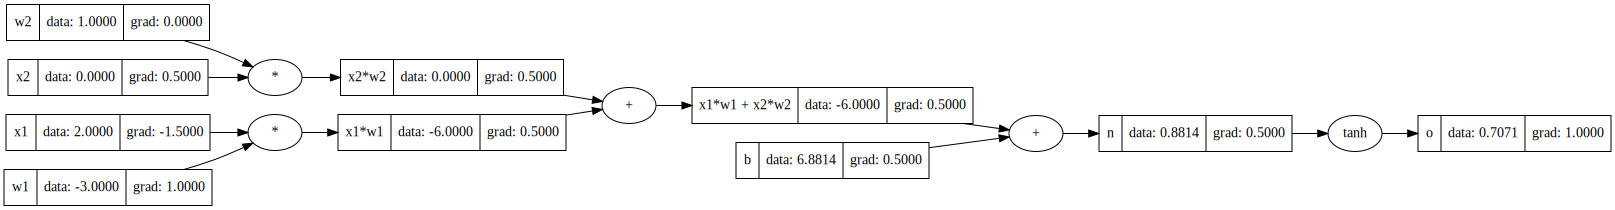

In [39]:
backward(o)
graphVisualizer(o)

All the code above has been copied into the Value class in Part 2. We're done with autograd!

--

Last thing: Let's show that there's no difference numerically between using atomic tanh, 
or tanh made up of other atomic functions. 

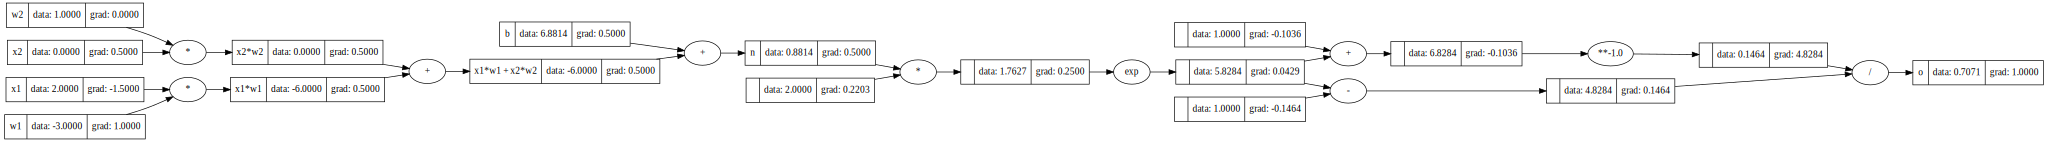

In [40]:
resetTestNeuron(False)
o.backward()
graphVisualizer(o)

##### Part 6.1: Messing around

In [41]:
def test6_1():
    a = Value(1.0, label='a')
    b = Value(1.0, label='b')

    w_1a = Value(1.0, label='w_1a')
    w_2a = Value(1.0, label='w_2a')
    w_3a = Value(1.0, label='w_3a')

    w_1b = Value(1.0, label='w_1b')
    w_2b = Value(1.0, label='w_2b')
    w_3b = Value(1.0, label='w_3b')

    # Does python follow operator precedence for custom operators?
    c = (a * w_1a) + (b * w_1b)
    d = (a * w_2a) + (b * w_2b)
    e = (a * w_3a) + (b * w_3b)

    w_1c = Value(0.23, label='w_1c')
    w_1d = Value(0.67, label='w_1d')
    w_1e = Value(-1.55, label='w_1e')

    f = (c * w_1c) + (d * w_1d) + (e * w_1e)
    o = f.tanh()

    o.backward()
    graphVisualizer(o)

#### Part 7: More `Value` operators

I will rewrite tanh as a combination of other atomic operators such as exp, div, etc.

Restating a comment made above:
We can write out the tanh function explicitly by implementing
__sub__, __div__, and exp. But it's not necessary to have 
these atomic computational pieces. You can have something as 
simple as an addition operator or something arbitrarily complex, 
but the most important thing is that you know how to differentiate
the function you implement so you can compute the "local" partial 
derivative and chain it to the global derivative.

Also, python has `__radd__`, `__rsub__`, etc. methods. If you have implemented
`__add__`, `a + b` is the same as `a.__add__(b)`. If you did `1 + b`, python
tries to do `1.__add__(b)` but integers don't know how to add `Value` objects to 
themselves. If this happens, python checks if the `__radd__` method is implemented,
and calls it instead 

#### Part 8: Autograd with Pytorch

Micrograd is a scalar valued autograd engine. PyTorch uses tensors and thus differentiation is more complex. We can emulate micrograd using using 1x1 tensors.

Pytorch is more efficient specifically because it operates on these tensors and can parallelize computations.

In [43]:
import torch

# Copied directly from Andrej's notebook

# by default, tensors are float32s. Cast to double (float64)
# since we are using floats in our engine. Since these are leaf
# nodes, (inputs) they do not require gradients by default. 

def pytorch_example():
    x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
    x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
    w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
    w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
    b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
    n = x1*w1 + x2*w2 + b
    o = torch.tanh(n)

    # .data and .grad attributes just like micrograd
    # .item() returns the element in single element tensors 

    print(o.data.item())
    o.backward()

    print('---')
    print('x2', x2.grad.item())
    print('w2', w2.grad.item())
    print('x1', x1.grad.item())
    print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


---

#### Part 9: Multi-layer perceptron

It's finally time to use our autograd engine to build a mini neural net library

In [44]:
import random

In [45]:
# Single NN Neuron
class Neuron:

    def __init__(self, numInputs):

        self.weights = [Value(random.uniform(-1, 1)) for _ in range(numInputs)]
        self.bias = Value(random.uniform(-1, 1))
    
    # forward(x)
    # x should be a list of ints/floats or Value() objects of size numInputs.
    def __call__(self, x):
        # assert(len(x) == len(self.weights))

        # zip returns an iterator of tuples: (self.weights[i], x[i]) pairs
        # sum() takes in an optional starting value
        rawActivation = sum((w * x_i for w, x_i in zip(self.weights, x)), start=self.bias)        
        return rawActivation.atomic_tanh()

    # Identical to __call__, but implemented in an explicit, non-pythonic way
    # to clearly see the use of the Value operators we defined
    def explicit_call(self, x):
        assert(len(x) == len(self.weights))

        # Explicit (non-pythonic)
        rawActivation = self.bias
        for i in range(len(self.weights)):
            # This uses the add and multiply operators in Value
            # (Not using += because we would need to define __iadd__ for that)
            rawActivation = rawActivation + self.weights[i] * x[i]
        return rawActivation.atomic_tanh()

    # Every module in pytorch has a parameters method that returns all the 
    # parameters of that module
    def parameters(self):
        return self.weights + [self.bias]
    
    def __repr__(self) -> str:
        return f'Neuron(numInputs={len(self.weights)}, act=tanh)'

In [46]:
n = Neuron(2)
n([1, 2])

Value(data=0.9845432327257068)

In [47]:
class Layer:
    
    def __init__(self, inputDim, outputDim):
        # the output of each neuron call n(x) is a Value() object
        self.inputDim = inputDim
        self.neurons = [Neuron(inputDim) for _ in range(outputDim)]
    
    # x should be list of Value objects with len(x) = inputDim
    # It represents the activations of the previous layer.
    # The list should either be the list of inputs, or a list generated a layer call
    def __call__(self, x):
        # if layer only has a single neuron, 
        return [n(x) for n in self.neurons]
    
    def parameters(self):
        # nested for-loop list comprehension
        return [param for neuron in self.neurons for param in neuron.parameters()]

    def __repr__(self) -> str:
        return f'Layer(inp={self.inputDim}, out={len(self.neurons)})'

In [48]:
inp = [1, 2, 3]
l1 = Layer(3, 5)
l1(inp)

[Value(data=0.9677315870279645),
 Value(data=0.947879978635107),
 Value(data=0.985826313473856),
 Value(data=0.9937599290644403),
 Value(data=-0.9737308924517851)]

In [49]:
class MLP:

    # format based on pytorch MLP (using list of hiddenDims to specify MLP shape)
    def __init__(self, inputDim, hiddenDims=[5]):
        self.layers = []
        prevDim = inputDim
        for dim in hiddenDims:
            self.layers.append(Layer(prevDim, dim))
            prevDim = dim
        
    # x should be a list numbers or Values of size inputDim
    def __call__(self, x):
        # Is there a pythonic way to do this? 
        transformed = x
        for layer in self.layers:
            transformed = layer(transformed)
        return transformed

    def parameters(self):
        return [param for layer in self.layers for param in layer.parameters()]
    
    def __repr__(self) -> str:
        return str(self.layers)
                

If I have multiple outputs, I can apply softmax to each
of activations to obtain a probability distribution, then
pipe these into a loss function (using the same Value functionality!)
I would just need to define SoftMax and Loss layers

In [50]:
mlp = MLP(1, [2, 1])
print(mlp)

# Ah I see the problem with needing to package everything as a tensor,
# even single element items, and then needing to "unwrap" single element
# outputs with .item()
output = mlp([5])

# output[0].backward()
# graphVisualizer(output[0])

output

[Layer(inp=1, out=2), Layer(inp=2, out=1)]


[Value(data=-0.6892855895289877)]

For convenience, Andrej modified `Layer` to output a number (instead of a list) if the 
size of the layer is 1. If this layer is the end of an MLP, this works. However, if that
final 1-length layer is then used as an input for some other layers, there will be an 
error in the `Neuron` class because it expects its input x to be a list.  

##### Part 9.1: Loss and Backprop with an Example Dataset

In [51]:
# Copied directly from Andrej's notebook
xs = [
  # thirst, sleep quality, tiredness
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]

# Range of y: {-1, 1}
# this dataset represents a simple binary classification problem (-1 or 1)
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [52]:
mlp = MLP(3, [4, 4, 1])
yPred = [mlp(x) for x in xs]
yPred

[[Value(data=0.579921714532488)],
 [Value(data=-0.4829384524960645)],
 [Value(data=-0.3919600809007914)],
 [Value(data=0.314850203568839)]]

I went back to Value and implemented `mse` and `optimize`. 

Each run of the 2 next cells constitutes one epoch of training. And you can 
see the loss for each individual training example decreasing, and the 
predictions getting closer and closer to the actua value.

In [53]:
loss = [pred[0].mse(gold) for gold, pred in zip(ys, yPred)]
loss

# loss[1] is very low because the current value of yPred[1]
# is -0.9, which is pretty close to the actual value of -1


[Value(data=0.1764657659213245),
 Value(data=0.26735264390716457),
 Value(data=0.36971254321817215),
 Value(data=0.4694302435496614)]

In [54]:
lr = 0.01
for l in loss:
    l.backward()
    l.optimize(lr)

yPred = [mlp(x) for x in xs]
yPred

[[Value(data=0.6349589433860066)],
 [Value(data=-0.5364979521977031)],
 [Value(data=-0.4372216507135989)],
 [Value(data=0.3654730117209426)]]

##### 9.2 My training and loss functions

In [55]:
def predict(model, xs):
    return [model(x) for x in xs]

def _train(model: MLP, xs, ys, epochs=5, lr=0.01):

    loss_per_epoch = []

    print("Training...")
    for i in range(epochs):
        yPred = predict(model, xs)
        loss = [pred[0].mse(gold) for gold, pred in zip(ys, yPred)]

        totalLoss = sum(loss).data
        print(f"Total loss at epoch {i}: {totalLoss}")
        loss_per_epoch.append(totalLoss)

        # There's was a bug here! The computational graph is 
        # continuing to accumulate gradients without resetting
        # them after each training example. It was not apparent
        # because the loss was going down anyway, but this
        # will cause problems in general as the gradient at
        # end of each backprop would be incorrect.
        
        # We will reset gradients to 0 in the optimize 
        # function after they are added to the node's data.

        lr = 0.01
        for l in loss:
            l.backward()
            l.optimize(lr)
        yPred = [mlp(x) for x in xs]
    
    return loss_per_epoch

Golds: [1.0, -1.0, -1.0, 1.0]
Initial predictions: [[Value(data=0.7233469431576075)], [Value(data=0.408902881306858)], [Value(data=-0.23381894518204852)], [Value(data=0.5438052472523355)]]
Training...
Total loss at epoch 0: 2.8566913040114583
Total loss at epoch 1: 2.414697453129666
Total loss at epoch 2: 2.0176122514685293
Total loss at epoch 3: 1.6944723439859637
Total loss at epoch 4: 1.4483068563152146
Total loss at epoch 5: 1.2622118204177892
Total loss at epoch 6: 1.1174897495104559
Total loss at epoch 7: 1.0008748774454608
Total loss at epoch 8: 0.9040919723696716
Total loss at epoch 9: 0.8220229324235027
Total loss at epoch 10: 0.7513692046791278
Total loss at epoch 11: 0.6898801159967376
Total loss at epoch 12: 0.63593217208952
Total loss at epoch 13: 0.5882985052104587
Total loss at epoch 14: 0.5460182399297522
Total loss at epoch 15: 0.5083188345516683
Total loss at epoch 16: 0.47456731445701617
Total loss at epoch 17: 0.4442379024240569
Total loss at epoch 18: 0.41688940513

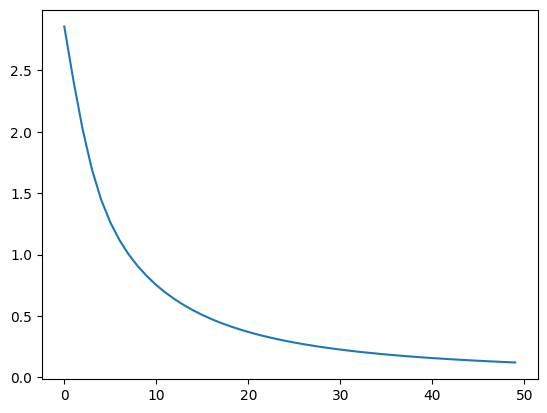

In [56]:
model = MLP(3, [4, 4, 1])

print("Golds:", ys)
print("Initial predictions:", predict(model, xs))

loss_per_epoch = _train(model, xs, ys, epochs=50)

print("Trained predictions:", predict(model, xs))

plt.plot(loss_per_epoch)

##### 9.3 Andrej Training and Loss (gradients based on combined sum of losses for each example)

I looped over each training example and performed backprop for each example. Andrej takes the sum of the losses of each training example and performs gradient descent with respect to this sum. The outcome should be relatively similar.

If I visualize the computational graph after one backward pass of my method, you'll see the expected computational graph for the MLP. However, if you visualize the computational graph using the sum of losses, it will be a massive graph that consists of 4 instances of our MLP each feeding into the final sum that results in the total loss. The gradients produced by each example will be accumulated in the weights

Instead of the optimize function being another backward pass through the network, we create a "parameters" for each module in our neural network architecture. This method returns all the tunable paramaters (weights and biases) of that module. In this way, an MLP can collect all the parameters of its layers, and a layer can collect all parameters of its neurons. 

1. Get list of predictions
2. Create combined loss sum
6. reset gradients to 0 before running backward pass
3. backward pass starting at combined loss to accumulate gradients
4. get parameters of model
5. increment each param (which is a Value object) with `lr * param.grad`

Optimizer modules in pytorch take the list of model parameters and the learning rate to perform a gradient descent step


In [62]:
class Optimizer:

    # params is a list of Value objects
    def __init__(self, params, lr=0.01):
        self.params = params
        self.lr = lr
    
    def step(self):
        for param in self.params:
            # move in opposite direction of gradient
            param.data -= lr * param.grad
    
    def zero_grad(self):
        for param in self.params:
            param.grad = 0.0

In [74]:
"""
*args and **kwargs are special keywords that can be 
used as function arguments.

*args: list of all non-keyword arguments passed to function
**kwargs: dictionary of all keyword args passed to the function

Your function can still accept other positional and keyword args.
*args and **kwargs must be the last function arguments, and they will
NOT contain the other arguments specified in the function definition
"""

def vprint(verbose=True, *args, **kwargs):
    if verbose:
        print(*args, **kwargs)

def predict(model, xs):
    return [model(x) for x in xs]

def train(model: MLP, xs, ys, epochs=25, lr=0.01, verbose=True):

    optimizer = Optimizer(model.parameters(), lr)
    loss_per_epoch = []

    vprint(verbose, "Training...")
    for i in range(epochs):
        yPred = predict(model, xs)

        # batch loss
        # loss is just another layer in the computational graph!
        loss = sum(pred[0].mse(gold) for pred, gold in zip(yPred, ys))
        loss_per_epoch.append(loss.data)

        if i % 5 == 0:
            vprint(verbose, f"Loss at epoch {i}: {loss.data}")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return loss_per_epoch

Golds: [1.0, -1.0, -1.0, 1.0]
Initial preds: [[Value(data=-0.36446265047458487)], [Value(data=-0.8804278468160768)], [Value(data=-0.6702876701055145)], [Value(data=-0.7740839259031368)]]
Training...
Loss at epoch 0: 5.132139820989506
Loss at epoch 5: 1.4983754910655525
Loss at epoch 10: 0.7599572787439595
Loss at epoch 15: 0.4476005935551258
Loss at epoch 20: 0.2990111178893467
Loss at epoch 25: 0.21810177901248518
Loss at epoch 30: 0.16892986325060286
Loss at epoch 35: 0.1365061047129989
Loss at epoch 40: 0.11378552295795395
Loss at epoch 45: 0.09710851211043994
Trained preds: [[Value(data=0.9423728291758261)], [Value(data=-0.9001568986100181)], [Value(data=-0.8179103844194721)], [Value(data=0.8051427587463633)]]


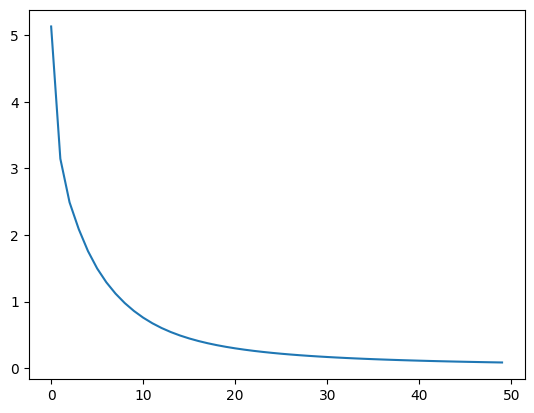

In [84]:
model = MLP(3, [4, 4, 1])

print("Golds:", ys)
print("Initial preds:", predict(model, xs))

loss = train(model, xs, ys, epochs=50, lr=0.1)
plt.plot(loss)

# Currently, we're predicting values. It would be easy add a 
# classification layer which predicts any positive values as 1,
# and negative values as -1
print("Trained preds:", predict(model, xs))


In [80]:
print("Num. model parameters", len(model.parameters()))
model.parameters()[0:5]

41


[Value(data=-0.31370718608477804),
 Value(data=-0.06007059879368387),
 Value(data=-1.3187395932603871),
 Value(data=0.8667226443822594),
 Value(data=0.4167195989107428)]

The gradient tells us the direction in which the function increases the greatest if you take infinitesimally small step. 
- We only know information about this really small and local area of the loss landscape. 
- We scale the gradient by a learning rate which we have to choose. Some optimizers start with a high learning rate and slow down over time. 
- If we take too large of a step, we may actually "jump" over some local minimum, and in some cases, it may cause the loss to skyrocket. 

Learning rate
- If learning rate is too high, loss can explode.
- If it's too low, we take too large to converge.

Mwahaha I caught the zero-grad bug before Andrej

#### Part 10: Micrograd Github

- Different non-linearties like tanh, relu, etc. really aren't *that* different. 
- There is a top level Module class which is the super class of all modules like Neuron, Layer, and MLP and acts as interface with methods like `__call__` and `parameters`
    - Similar to PyTorch API
- `batch` forward:
    - For large datasets, instead of calling forwards on the entire dataset during each epoch, we break it up into smaller chunks

Other Losses
- Cross Entropy Loss
- Max-Margin Loss

Other Stuff
- L2 Regularization to prevent overfitting

Pytorch
- Pytorch is large and reading through it is unwieldly, and it was pretty hard to find tanh in the codebase. "Meant to be used, not inspected" - Andrej. I think the point is that is that its a huge library that's been worked on by several people 
- [Defining new autograd functions](https://pytorch.org/tutorials/beginner/examples_autograd/two_layer_net_custom_function.html)
    - Just need to be able to do a forward pass and find the local derivative